In [1]:
import time, matplotlib, sklearn

# data wrangling
import pandas as pd
import numpy as np 

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer

# the data intro has been tested with the following versions
print("pandas        Tested version: 2.0.3   Your version: %s" % pd.__version__)
print("numpy         Tested version: 1.21.5  Your version: %s" % np.__version__)
print("matplotlib    Tested version: 3.5.3   Your version: %s" % matplotlib.__version__)
print("scikit-learn  Tested version: 1.2.2   Your version: %s" % sklearn.__version__)

pandas        Tested version: 2.0.3   Your version: 2.0.3
numpy         Tested version: 1.21.5  Your version: 1.21.5
matplotlib    Tested version: 3.5.3   Your version: 3.5.3
scikit-learn  Tested version: 1.2.2   Your version: 1.2.2


In [2]:
# description
description = pd.read_csv('''C:\\Users\\20212464\\OneDrive - TU Eindhoven\\Desktop\\Responsible Ds\\Responsible Ds\\WiDS_Datathon_2020_Dictionary.csv''')
description_dict = description.set_index('Variable Name').to_dict(orient='index')
# data
df = pd.read_csv('''C:\\Users\\20212464\\OneDrive - TU Eindhoven\\Desktop\\Responsible Ds\\Responsible Ds\\training_v2.csv''')

df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [3]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus val split
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.8  # maximum percentage of missing values for a column to be dropped

In [4]:
start_time = time.time()

# save features
X = df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
                    'apache_2_bodysystem'], # drop because of similarity with apache_3j_bodysystem
                   axis=1)
# save target variable
y = df['hospital_death'].copy()
# save APACHE scores for later evaluation on train / test / validation data
y_apache = df['apache_4a_hospital_death_prob'].copy()

""" SPLIT DATA SET """
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache, 
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test, 
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 

"""MISSING VALUES"""
# drop columns with many missing values
missing = X_train.isna().sum() > max_missing * len(X_train)
missing = missing[missing].index
X_train = X_train.drop(missing, axis=1)
X_val = X_val.drop(missing, axis=1)
X_test = X_test.drop(missing, axis=1)

"""FURTHER PROCESSING PIPELINE"""
# define pre-processing steps for numerical features
num_transformer = Pipeline(steps=[("constant", VarianceThreshold()), # remove constant features
                                  ("imputer", SimpleImputer(strategy="mean")),
                                 ])
# define preprocessing steps for categorical features
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore"))])
# create preprocessing pipeline
prep_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_exclude=object)), # apply to columns NOT of type object (int or float)
        ('cat', cat_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object
    ])
# pipeline
prep_pipeline.fit(X_train, y_train)
display(prep_pipeline) # disply preprocessing pipeline

# transform data sets
X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('constant',
                                                  VarianceThreshold()),
                                                 ('imputer', SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002E282C9BE50>),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002E282CBE490>)])

Time: 2.13s
Train set: 73370 rows, 184 columns
Validation set: 9171 rows, 184 columns
Test set: 9172 rows, 184 columns


In [5]:
print("Cleaned Training Set:")
traindf = pd.DataFrame(X_train)
traindf.head()

print("\nCleaned Validation Set:")
valdf = pd.DataFrame(X_val) 
valdf.head()

print("\nCleaned Test Set:")
testdf = pd.DataFrame(X_test) 
testdf.head()

Cleaned Training Set:

Cleaned Validation Set:

Cleaned Test Set:


,num__age,num__bmi,num__elective_surgery,num__height,num__pre_icu_los_days,num__weight,num__albumin_apache,num__apache_2_diagnosis,num__apache_3j_diagnosis,num__apache_post_operative,...,cat__apache_3j_bodysystem_Genitourinary,cat__apache_3j_bodysystem_Gynecological,cat__apache_3j_bodysystem_Hematological,cat__apache_3j_bodysystem_Metabolic,cat__apache_3j_bodysystem_Musculoskeletal/Skin,cat__apache_3j_bodysystem_Neurological,cat__apache_3j_bodysystem_Respiratory,cat__apache_3j_bodysystem_Sepsis,cat__apache_3j_bodysystem_Trauma,cat__apache_3j_bodysystem_nan
0,52.0,44.404503,1.0,162.6,7.956944,117.4,2.90288,308.0,1207.01,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,57.0,26.260906,0.0,175.3,0.136806,80.7,2.90288,112.0,107.01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,84.0,14.844926,0.0,165.0,0.706250,38.6,2.10000,113.0,501.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,58.0,28.307058,0.0,170.2,0.175000,82.0,3.50000,123.0,702.01,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,67.0,29.393718,1.0,185.0,0.487500,100.6,2.50000,304.0,1411.01,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Define the parameter grid, including classifier parameters
param_grid = {
    'classifier__n_estimators': [int(x) for x in np.linspace(start=10, stop=80, num=10)],
    'classifier__max_features': ['auto', 'sqrt'],
    'classifier__max_depth': [2, 4],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True, False]
}

# Combine the preprocessing pipeline with the classifier
full_pipeline = Pipeline(steps=[
    ('preprocessor', prep_pipeline),
    ('classifier', RandomForestClassifier(random_state=random_state))
])

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(full_pipeline, param_distributions=param_grid, n_iter=10, scoring='roc_auc', cv=3, random_state=random_state)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate on validation set
y_val_pred = random_search.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_pred)
print("Validation ROC AUC:", roc_auc)


C:\Users\20212464\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\20212464\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\20212464\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

Best hyperparameters: {'classifier__n_estimators': 33, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 4, 'classifier__bootstrap': True}
Validation ROC AUC: 0.8534290107252681


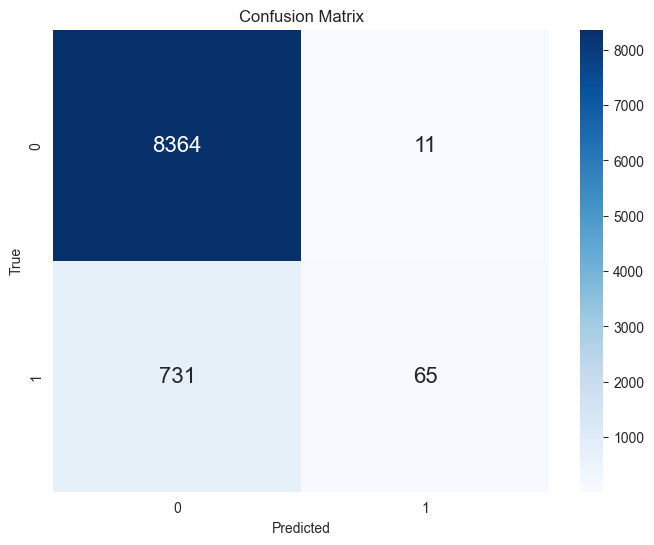

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the validation set
y_val_pred = random_search.predict(X_val)

# Create confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
#the problem is the false positives, precision is a good way to measure it

In [8]:
from sklearn.metrics import f1_score, accuracy_score

# Calculate F1 score
f1 = f1_score(y_val, y_val_pred)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)

# Print F1 score and accuracy
print("F1 Score: {:.4f}".format(f1))
print("Accuracy: {:.4f}".format(accuracy))


F1 Score: 0.1491
Accuracy: 0.9191


In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# Predictions from the model
y_pred = random_search.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Positive Predictive Value (PPV) or Precision
ppv = precision_score(y_test, y_pred)

# Negative Predictive Value (NPV)
npv = tn / (tn + fn)

# False Positive Rate (FPR)
fpr = fp / (fp + tn)

# False Negative Rate (FNR)
fnr = fn / (fn + tp)

# Conditional Demographic Parity
cond_demographic_parity = tp / (tp + fp)

# Equal Calibration
equal_calibration = tp / (tp + fn)

# Equal Odds
equal_odds = (tp / (tp + fn)) == (tn / (tn + fp))

# F1 Score
f1 = f1_score(y_test, y_pred)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, random_search.predict_proba(X_test)[:, 1])

import pandas as pd

# Calculate the metrics
metrics = {
    "Metric": ["Accuracy", "False Negatives", "False Positives", "Positive Predictive Value (PPV)", 
               "Negative Predictive Value (NPV)", "False Positive Rate (FPR)", "False Negative Rate (FNR)",
               "Conditional Demographic Parity", "Equal Calibration", "Equal Odds", "F1 Score", "ROC-AUC Score"],
    "Value": [accuracy, fn, fp, ppv, npv, fpr, fnr, cond_demographic_parity, equal_calibration, 
              equal_odds, f1, roc_auc]
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame
print(metrics_df)


                             Metric     Value
0                          Accuracy  0.918993
1                   False Negatives       732
2                   False Positives        11
3   Positive Predictive Value (PPV)  0.842857
4   Negative Predictive Value (NPV)  0.919578
5         False Positive Rate (FPR)  0.001312
6         False Negative Rate (FNR)  0.925411
7    Conditional Demographic Parity  0.842857
8                 Equal Calibration  0.074589
9                        Equal Odds     False
10                         F1 Score   0.13705
11                    ROC-AUC Score  0.848661
